In [1]:
import sys
sys.path.append('../../')

In [2]:
import datas.income2023f as income2023f

Loading Data
Finished Loading Data


In [3]:
import sklearn
import numpy as np

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [5]:
def preprocess(df):
    df = df.copy()
    return_y = False
    if 'income>50K' in df.columns:
        return_y = True
        y = np.array(list(df['income>50K']))
    df.drop(columns=['ID', 'income>50K'], inplace=True, errors='ignore')
    
    ret = [] #np.zeros(shape=[len(df), len(df.columns)], dtype=np.float32)
    
    for i, row in df.iterrows():
        dp = [
            row.age,
            *row.workclass,
            row.fnlwgt,
            *row.education,
            row['education.num'],
            *row['marital.status'],
            *row.occupation,
            *row.relationship,
            *row.race,
            *row.sex,
            row['capital.gain'],
            row['capital.loss'],
            row['hours.per.week'],
            *row['native.country']
        ]
        dp.extend(np.multiply(dp, dp))
        dp.extend(np.cos(dp))
        ret.append(dp)
    
    if return_y:
        return np.array(ret), y
    return np.array(ret)

In [6]:
train, train_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_training_partition])
validation, validation_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_valdiation_partition])

In [13]:
# C_range = np.logspace(-2, 10, 3)
# gamma_range = np.logspace(-9, 3, 3)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
dtc = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth=3)
)
# grid = GridSearchCV(svc, param_grid=param_grid, cv=cv)

In [14]:
train_y.shape

(20000,)

In [15]:
# grid.fit(train, train_y)
# print(
#     "The best parameters are %s with a score of %0.2f"
#     % (grid.best_params_, grid.best_score_)
# )
dtc.fit(train, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

(20000,) (20000,)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

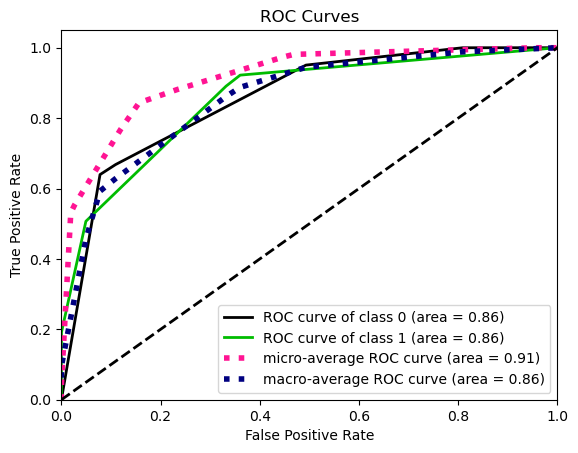

In [16]:
train_pred = dtc.predict_proba(train)[:,1]
print(train_y.shape, train_pred.shape)
import scikitplot as skplt
skplt.metrics.plot_roc(
    train_y,
    np.array([
        1-train_pred,
        train_pred
    ]).T
)

(5000,) (5000,)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

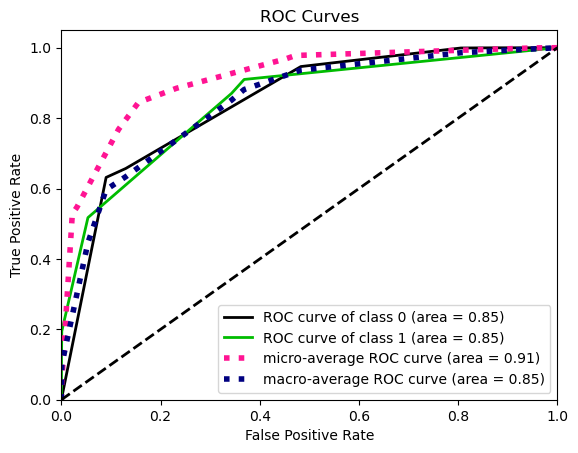

In [17]:
validation_pred = dtc.predict_proba(validation)[:,1]
print(validation_y.shape, validation_pred.shape)
import scikitplot as skplt
skplt.metrics.plot_roc(
    validation_y,
    np.array([
        1-validation_pred,
        validation_pred
    ]).T
)

# Now, train on full data with equivalent hyperparameters

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

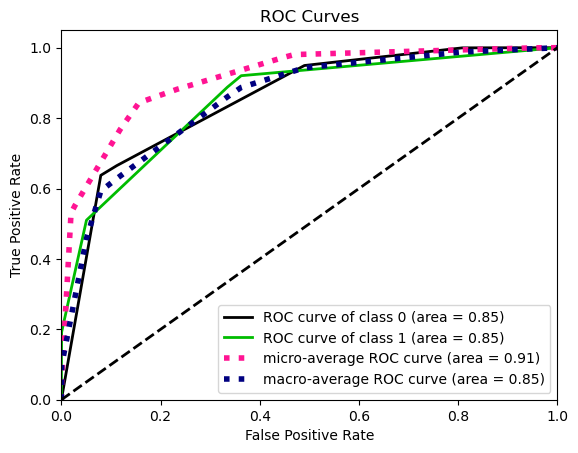

In [18]:
train_full, train_full_y = preprocess(income2023f.train_preprocessed)
mlp_full = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth=3)
)
mlp_full.fit(train_full, train_full_y)
train_full_pred = mlp_full.predict_proba(train_full)[:,1]
skplt.metrics.plot_roc( # ensure nothing terrible happened, not useful roc
    train_full_y,
    np.array([
        1-train_full_pred,
        train_full_pred
    ]).T
)

In [ ]:
test = preprocess(income2023f.test_preprocessed)
test_pred = mlp_full.predict_proba(test)[:,1]

In [ ]:
import pandas as pd
pd.DataFrame(
    {
        'ID': list(range(1, 23843)),
        'Prediction':test_pred
    }
).to_csv('./decisiontree_test_predictions.csv', index=False)